In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io as sio #to load mat files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

<h1> 1. Loading CMU Faces dataset </h1>

In [2]:
print sio.whosmat('../datasets/CMU(30x11x21x1024).mat')
matTF = sio.loadmat('../datasets/CMU(30x11x21x1024).mat')#loading tensor of formatted faces' images
TF = matTF['FullTensor']
print TF.shape
MF = np.reshape(TF,(30*11*21,1024))
print MF.shape

[('FullTensor', (30, 11, 21, 1024), 'uint8')]
(30, 11, 21, 1024)
(6930, 1024)


<h2> Preprocessing incomplete objects </h2>

In [3]:
rt_obinc = 0.4 # rate of objects incomplete
rt_incpob = 0.1 # rate of minimun elements (attributes or variables) incomplete for each object
idx_inc = np.sort(np.random.choice(MF.shape[0], int(MF.shape[0]*rt_obinc), replace=False))
idx_v = np.ones(MF.shape[0])
idx_v[idx_inc] = 0
idx_s = np.vstack((idx_v,idx_v)).repeat([1,MF.shape[1]-1],0).T
idx_com = np.arange(0,MF.shape[0]-1)
idx_com = np.delete(idx_com, idx_inc)

In [4]:
idx_s2 = np.copy(idx_s) # idx_s2 could have partially incomplete objects
for i in idx_inc:
    idx_s2[i] = np.random.permutation(np.append(np.ones(int(round(MF.shape[1]*(1-rt_incpob)))),np.zeros(int(round(MF.shape[1]*rt_incpob)))))

In [5]:
MF_ci = MF * idx_s2
MF_i = MF_ci[idx_inc]#subset with incomplete elements
MF_c = MF_ci[idx_com]#subset with complete elements

<h1>2. Pixel approach</h1>

Face: 30


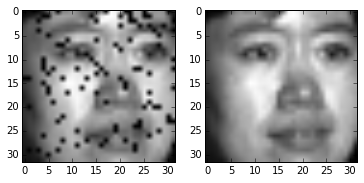

In [6]:
print 'Face:', idx_inc[10]
Pixel = MF_ci[idx_inc[10]]
Y = np.tile(np.arange(0,32),32)
X = np.repeat(np.arange(0,32),32)
data = np.stack((X.T,Y.T), axis = 0)
data = np.vstack((data,Pixel.T)).T
f, axarr = plt.subplots(1, 2)
axarr[0].imshow( np.reshape(MF_ci[idx_inc[10]],(32,32)).T, cmap='Greys_r' )
axarr[1].imshow( np.reshape(MF[idx_inc[10]],(32,32)).T, cmap='Greys_r' )

In [7]:
#Missing pixels
completes = range(0,1024)*idx_s2[idx_inc[10]]
incompletes = range(0,1024)
incompletes = np.delete(incompletes, completes).astype(int)
completes  = np.delete(completes, incompletes).astype(int)
print len(completes), len(incompletes)

922 102


In [8]:
import kernel as kernel
import pymf
from pymf.cnmf import CNMF 
from kcnmf import KCNMF 
import time

In [9]:
#parameters
nobj = len(completes)
sigmap = 100
sigmax = 0.5
sigmay = 0.5
bases = 300
normalize = 3

In [10]:
Kp = kernel._get_kernel(np.stack((Pixel[completes].T,np.zeros(len(completes)).T), axis = 1), np.stack((Pixel[completes].T,np.zeros(len(completes)).T), axis = 1),'rbf', gamma=(2*sigmap)**-2)

In [11]:
Kx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1),'rbf', gamma=(2*sigmax)**-2)

In [12]:
Ky = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1),'rbf', gamma=(2*sigmay)**-2)

In [13]:
#Tensorial kernel
Kt = Kp*Kx*Ky
#Kt = np.dot(Kp, np.dot(Kx,Ky))

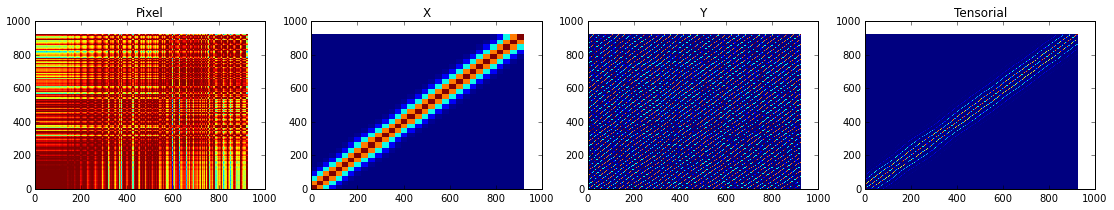

In [129]:
f, axarr = plt.subplots(1, 4)
axarr[0].pcolor(Kp)
axarr[0].set_title('Pixel')
axarr[1].pcolor(Kx)
axarr[1].set_title('X')
axarr[2].pcolor(Ky)
axarr[2].set_title('Y')
axarr[3].pcolor(Kt)
axarr[3].set_title('Tensorial')
f.set_size_inches(19,3)
#plt.colorbar()

In [39]:
rse_nmf = []
for i in range(10,200):
    cnmf_kpg = KCNMF(Kt,num_bases=i)
    cnmf_kpg.factorize(niter=10)
    rse_nmf.append( np.linalg.norm(Kt - np.dot(cnmf_kpg.W,cnmf_kpg.H))/np.linalg.norm(Kt))

0.241658476624


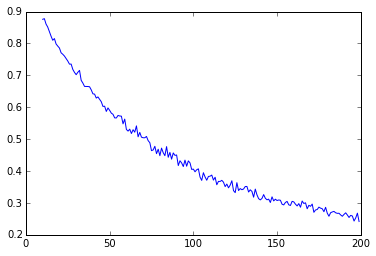

In [40]:
plt.plot(range(10,200),rse_nmf)
print min(rse_nmf)

In [14]:
#Factorize
cnmf_kpg = KCNMF(Kt,num_bases=bases)
cnmf_kpg.factorize(niter=10)
print '(rbf kernel) rse:',np.linalg.norm(Kt - np.dot(cnmf_kpg.W,cnmf_kpg.H))/np.linalg.norm(Kt)

(rbf kernel) rse: 0.549189370295


<matplotlib.colorbar.Colorbar instance at 0x7f1fa66b75a8>

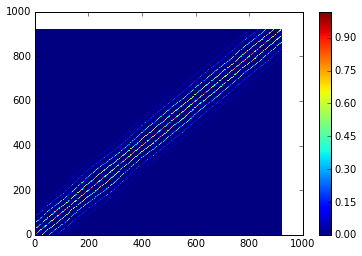

In [131]:
#\phi(X) = \phi(X)G*H = WH
plt.pcolor(np.dot(cnmf_kpg.W,cnmf_kpg.H))
plt.colorbar()

In [15]:
lamb = 1e-10
print 'Computing Hs...'
H4_i = np.zeros((bases, len(incompletes)))
for i in range(len(incompletes)):
    auxpi4 = np.linalg.inv(np.dot(cnmf_kpg.W.T, cnmf_kpg.G)+ lamb*np.identity(bases))
    #auxpi4 = np.dot(np.linalg.inv(np.dot(np.dot(cnmf_kpg.G.T,Kt),cnmf_kpg.G)),cnmf_kpg.G.T)#OKMF
    Ktx = np.ones((nobj,1))
    
    #It's not feasible compute K(X,x) for pixel since all missing pixel are 0
    Kxx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(X[incompletes[i]], 0),'rbf', gamma=(2*sigmax)**-2)
    Kyx = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(Y[incompletes[i]], 0),'rbf', gamma=(2*sigmay)**-2)
    Ktx = Kxx*Kyx
    #Ktx = Ksx+Kix
    H4_i[:,i] = np.squeeze(np.dot(auxpi4, np.dot(cnmf_kpg.G.T, Ktx) ))
    #H4_i[:,i] = np.squeeze(np.dot(auxpi4, Ktx )) #OKMF
    if normalize == 1:
        H4_i[:,i] = (H4_i[:,i]+abs(min(H4_i[:,i]))) / sum(H4_i[:,i]+abs(min(H4_i[:,i])))
    if normalize == 2:
        H4_i[:,i] = abs(H4_i[:,i])
    if normalize == 3:
        H4_i[:,i] = np.maximum(H4_i[:,i],0)
print '...Hs computed'

Computing Hs...
...Hs computed


<matplotlib.colorbar.Colorbar instance at 0x7f1fcb7b69e0>

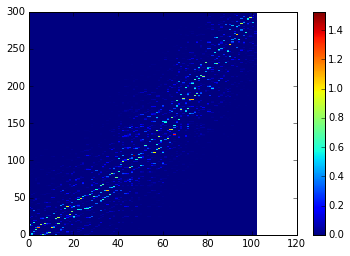

In [133]:
plt.pcolor(H4_i)
plt.colorbar()
#plt.savefig('/home/rajaquep/outcomes/<testH.png')

In [134]:
print 'Computing pre-image...'
normalize_alpha = 0
Pixel_preim = np.copy(Pixel)
rse_f = []
gamma_t = (2*sigmax)**-2+(2*sigmay)**-2
for i in range(len(incompletes)):
    print 'Compute pre-image for object',incompletes[i]
    #alpha = np.dot(cnmf_kpg.G, H4_i[:,i]) #np.mean(cnmf_kg.H,0)  
    alpha = np.dot(cnmf_kpg.W, H4_i[:,i]) #np.mean(cnmf_kg.H,0)  
    if normalize_alpha == 1:
        alpha = (alpha+abs(min(alpha))) / sum(alpha+abs(min(alpha)))*100
    if normalize_alpha == 2:
        alpha = abs(alpha)
    if normalize_alpha == 3:
        alpha = np.maximum(alpha,0)
    if normalize_alpha == 4:
        alpha = (alpha-min(alpha))/(max(alpha)-min(alpha))
    if normalize_alpha == 5:
        alpha = alpha*100
    #try:                
    aux, trainErrorskl = kernel.preimage(np.stack((Pixel[completes].T,np.zeros(len(completes)).T), axis = 1), alpha, 'rbf', gamma=gamma_t)
    print aux[0,0]
    Pixel_preim[incompletes[i]] = aux[0,0]    
    rse_f.append(np.linalg.norm(Pixel[incompletes[i]] - Pixel_preim[incompletes[i]])/np.linalg.norm(Pixel[incompletes[i]]))
    #except:
    #    print 'Problems computing preimage', i
    #    continue    
print '...pre-images computed'

Computing pre-image...
Compute pre-image for object 3
7.56031100175
Compute pre-image for object 7
7.49400573337
Compute pre-image for object 13
11.3388914685
Compute pre-image for object 22
11.6105546365
Compute pre-image for object 27
11.5988349565
Compute pre-image for object 36
7.88373351997
Compute pre-image for object 37
8.67148808369
Compute pre-image for object 39
7.6587041238
Compute pre-image for object 41
8.09686808728
Compute pre-image for object 42
8.29873384482
Compute pre-image for object 59
11.7254015986
Compute pre-image for object 60
11.4382163229
Compute pre-image for object 69
8.80755644346
Compute pre-image for object 72
7.90116174388
Compute pre-image for object 84
11.9021359632
Compute pre-image for object 90
11.8675175965
Compute pre-image for object 99
9.35777708344
Compute pre-image for object 108
6.94311938418
Compute pre-image for object 114
11.9844756393
Compute pre-image for object 135
7.4590418378
Compute pre-image for object 139
8.29376281386
Compute pre

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: divide by zero encountered in double_scalars


In [141]:
print 'Linear reconstruction...'
normalize_alpha = 0
Pixel_preim = np.copy(Pixel)
rse_f = []
gamma_t = (2*sigmax)**-2+(2*sigmay)**-2
for i in range(len(incompletes)):
    print 'Compute reconstruction for object',incompletes[i]
    alpha = np.dot(cnmf_kpg.G, H4_i[:,i]) #np.mean(cnmf_kg.H,0)        
    if normalize_alpha == 1:
        alpha = (alpha+abs(min(alpha))) / sum(alpha+abs(min(alpha)))
    if normalize_alpha == 2:
        alpha = abs(alpha)
    if normalize_alpha == 3:
        alpha = np.maximum(alpha,0)
    if normalize_alpha == 4:
        alpha = (alpha-min(alpha))/(max(alpha)-min(alpha))
    if normalize_alpha == 5:
        alpha = alpha*100
    #try:                
    #aux, trainErrorskl = kernel.preimage(np.stack((Pixel[completes].T,np.zeros(len(completes)).T), axis = 1), alpha, 'rbf', gamma=gamma_t)
    #print aux[0,0]
    #Pixel_preim[incompletes[i]] = aux[0,0]    
    Pixel_preim[incompletes[i]] = np.dot(Pixel[completes].T, alpha)
    rse_f.append(np.linalg.norm(Pixel[incompletes[i]] - Pixel_preim[incompletes[i]])/np.linalg.norm(Pixel[incompletes[i]]))
    #except:
    #    print 'Problems computing preimage', i
    #    continue    
print '...reconstruction computed'

Linear reconstruction...
Compute reconstruction for object 3
Compute reconstruction for object 7
Compute reconstruction for object 13
Compute reconstruction for object 22
Compute reconstruction for object 27
Compute reconstruction for object 36
Compute reconstruction for object 37
Compute reconstruction for object 39
Compute reconstruction for object 41
Compute reconstruction for object 42
Compute reconstruction for object 59
Compute reconstruction for object 60
Compute reconstruction for object 69
Compute reconstruction for object 72
Compute reconstruction for object 84
Compute reconstruction for object 90
Compute reconstruction for object 99
Compute reconstruction for object 108
Compute reconstruction for object 114
Compute reconstruction for object 135
Compute reconstruction for object 139
Compute reconstruction for object 146
Compute reconstruction for object 149
Compute reconstruction for object 151
Compute reconstruction for object 156
Compute reconstruction for object 162
Comput

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: divide by zero encountered in double_scalars


In [85]:
#print Pixel_preim[incompletes] - MF[idx_inc[10]][incompletes]
print Pixel_preim[incompletes]
#print MF[idx_inc[10]][incompletes]

[ 162.97325413  191.21368944  196.74272926  182.61240752  197.53136587
  189.97267796  185.80956919  215.36360062  205.53807805  246.0338543
  282.7190738   236.13228431  225.42713228  152.97980344  209.40617585
  209.46315093  208.65325093  221.37645928  244.8265192   322.86155293
  319.74019316  318.01074092  359.77126066  261.30405332  280.68555643
  280.17757868  238.01467908  356.5336619   323.98761772  180.19870324
  267.45432014  218.8965199   232.8075827   252.40040009  243.4860982
  244.44553274  291.36782097  365.51568619  423.39352502  350.81621061
  315.37065466  340.08523873  381.15957383  321.25144008  374.30213322
  450.19059491  436.31177144  366.38227574  254.68721527  225.45155198
  224.0634967   283.56007317  278.80398521  286.11596457  323.97664937
  437.68845728  452.16806162  447.72235813  416.39004575  460.56864259
  433.73743293  410.72433374  376.04716541  410.53189656  538.42781028
  336.05010683  299.11001961  347.01826294  251.78725807  230.60440775
  279.81

In [158]:
print 'Linear reconstruction 2...'
normalize_alpha = 0
Pixel_preim = np.copy(Pixel)
rse_f = []
gamma_t = (2*sigmax)**-2+(2*sigmay)**-2
for i in range(len(incompletes)):
    print 'Compute reconstruction for object',incompletes[i]
    Kxx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(X[incompletes[i]], 0),'rbf', gamma=(2*sigmax)**-2)
    Kyx = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(Y[incompletes[i]], 0),'rbf', gamma=(2*sigmay)**-2)
    Ktx = Kxx*Kyx
    alpha = Ktx    
    Pixel_preim[incompletes[i]] = np.dot(Pixel[completes].T, alpha)
    rse_f.append(np.linalg.norm(Pixel[incompletes[i]] - Pixel_preim[incompletes[i]])/np.linalg.norm(Pixel[incompletes[i]]))    
print '...reconstruction computed'

Linear reconstruction 2...
Compute reconstruction for object 4
Compute reconstruction for object 5
Compute reconstruction for object 7
Compute reconstruction for object 9
Compute reconstruction for object 11
Compute reconstruction for object 12
Compute reconstruction for object 16
Compute reconstruction for object 17
Compute reconstruction for object 18
Compute reconstruction for object 20
Compute reconstruction for object 23
Compute reconstruction for object 24
Compute reconstruction for object 25
Compute reconstruction for object 26
Compute reconstruction for object 27
Compute reconstruction for object 28
Compute reconstruction for object 31
Compute reconstruction for object 32
Compute reconstruction for object 34
Compute reconstruction for object 36
Compute reconstruction for object 42
Compute reconstruction for object 46
Compute reconstruction for object 50
Compute reconstruction for object 51
Compute reconstruction for object 53
Compute reconstruction for object 54
Compute reconst

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: divide by zero encountered in double_scalars


In [39]:
print 'Computing pre-image...'
normalize_alpha = 6
Pixel_preim = np.copy(Pixel)
rse_f = []
gamma_t = (2*sigmax)**-2+(2*sigmay)**-2
K_pr1_i = np.zeros((len(completes),len(incompletes)))
K_pr2_i = np.zeros((len(completes),len(incompletes)))
for i in range(len(incompletes)):
    print 'Compute pre-image for object',incompletes[i]
    #alpha = np.dot(cnmf_kpg.G, H4_i[:,i]) #np.mean(cnmf_kg.H,0)  
    alpha = np.dot(cnmf_kpg.W, H4_i[:,i]) #np.mean(cnmf_kg.H,0)  
    if normalize_alpha == 1:
        alpha = (alpha+abs(min(alpha))) / sum(alpha+abs(min(alpha)))*100
    if normalize_alpha == 2:
        alpha = abs(alpha)
    if normalize_alpha == 3:
        alpha = np.maximum(alpha,0)
    if normalize_alpha == 4:
        alpha = (alpha-min(alpha))/(max(alpha)-min(alpha))
    if normalize_alpha == 5:
        alpha = alpha*100
    if normalize_alpha == 6:
        alpha = np.ones(alpha.shape)
    #try:                
    #aux, trainErrorskl = kernel.preimage(np.stack((Pixel[completes].T,np.zeros(len(completes)).T), axis = 1), alpha, 'rbf', gamma=gamma_t)
    Kxx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(X[i], 0),'other', gamma=(2*sigmax)**-2)    
    Kyx = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(Y[i], 0),'other', gamma=(2*sigmay)**-2)
    Ktx = Kxx*Kyx
    K_pr1_i[:,i] = Ktx
    Kxx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(X[i], 0),'rbf', gamma=(2*sigmax)**-2)    
    Kyx = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(Y[i], 0),'rbf', gamma=(2*sigmay)**-2)
    Ktx = Kxx*Kyx
    K_pr2_i[:,i] = np.squeeze(Ktx) 
    aux, trainErrorskl = kernel.pixel_preimage(Pixel[completes], Ktx, alpha, 'rbf', gamma=(2*sigmap)**-2)
    print aux
    #print X[i], Y[i]
    #print Ktx
    Pixel_preim[incompletes[i]] = aux
    rse_f.append(np.linalg.norm(Pixel[incompletes[i]] - Pixel_preim[incompletes[i]])/np.linalg.norm(Pixel[incompletes[i]]))
    #except:
    #    print 'Problems computing preimage', i
    #    continue    
print '...pre-images computed'

Computing pre-image...
Compute pre-image for object 14
[ 11.3141465]
Compute pre-image for object 46
[ 17.80838749]
Compute pre-image for object 52
[ 32.23096872]
Compute pre-image for object 61
[ 46.16033265]
Compute pre-image for object 64
[ 51.71664673]
Compute pre-image for object 98
[ 52.76081958]
Compute pre-image for object 100
[ 52.36308348]
Compute pre-image for object 125
[ 51.85563966]
Compute pre-image for object 129
[ 51.64410138]
Compute pre-image for object 138
[ 51.15295185]
Compute pre-image for object 139
[ 51.79774394]
Compute pre-image for object 140
[ 51.47333264]
Compute pre-image for object 143
[ 49.78436044]
Compute pre-image for object 154
[ 47.86661724]
Compute pre-image for object 161
[ 43.40444249]
Compute pre-image for object 165
[ 38.55521584]
Compute pre-image for object 173
[ 36.0016193]
Compute pre-image for object 176
[ 31.73700897]
Compute pre-image for object 177
[ 28.32150402]
Compute pre-image for object 190
[ 28.01135257]
Compute pre-image for obj

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/IPython/kernel/__main__.py:39: RuntimeWarning: divide by zero encountered in double_scalars


In [194]:
x = np.arange(-2,2,0.1)
x < 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False], dtype=bool)

In [45]:
print K_pr1_i[range(10),1]
print K_pr2_i[range(10),1]

[ 1.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
[  3.67879441e-01   1.00000000e+00   3.67879441e-01   1.83156389e-02
   1.23409804e-04   1.12535175e-07   1.38879439e-11   2.31952283e-16
   5.24288566e-22   1.60381089e-28]


<h3>Comparing approaches to reconstruct</h3>

RSE 0.218271564053
RSE** 0.669520302526


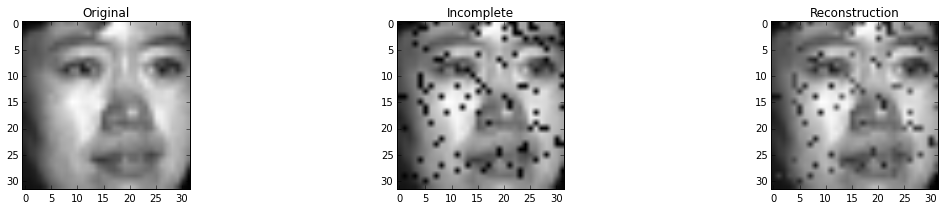

In [23]:
f, axarr = plt.subplots(1, 3)
axarr[0].imshow( np.reshape(MF[idx_inc[10]],(32,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original')
axarr[1].imshow( np.reshape(MF_ci[idx_inc[10]],(32,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete')
axarr[2].imshow( np.reshape(Pixel_preim,(32,32)).T, cmap='Greys_r' )
axarr[2].set_title('Reconstruction')
f.set_size_inches(19,3)
f.savefig('/home/rajaquep/outcomes/foo.png')
print 'RSE', np.linalg.norm(MF[idx_inc[10]] - Pixel_preim)/np.linalg.norm(MF[idx_inc[10]])
print 'RSE**', np.linalg.norm(MF[idx_inc[10]][incompletes] - Pixel_preim[incompletes])/np.linalg.norm(MF[idx_inc[10]][incompletes])

In [136]:
i_preimage_old = Pixel_preim[incompletes]

In [148]:
ori = MF[idx_inc[10]][incompletes]

In [143]:
i_alphaxintensity = Pixel_preim[incompletes]

In [140]:
i_preimage_upg = Pixel_preim[incompletes]

In [145]:
i_avg = AvgM[incompletes]
#RSE 0.126727507717
#RSE** 0.174734851699


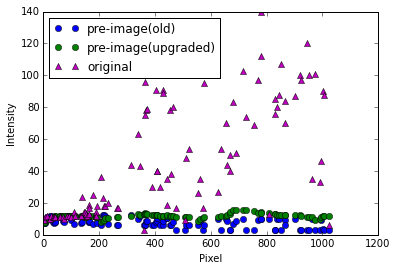

In [150]:
plt.plot(incompletes,i_preimage_old,'ob',label='pre-image(old)')
plt.plot(incompletes,i_preimage_upg,'og',label='pre-image(upgraded)')
#plt.plot(incompletes,i_avg,'oy',label='naive(avg)')
#plt.plot(incompletes,i_alphaxintensity,'-oc',label='alpha x intensity')
plt.plot(incompletes,ori,'^m',label='original')
plt.legend(loc=2)
plt.ylabel('Intensity')
plt.xlabel('Pixel')

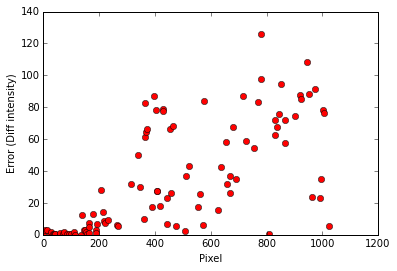

In [151]:
#plt.plot(incompletes,i_preimage_old,'ob',label='pre-image(old)')
plt.plot(incompletes,abs(ori-i_preimage_upg),'or')
#plt.plot(incompletes,i_avg,'oy',label='naive(avg)')
#plt.plot(incompletes,i_alphaxintensity,'-oc',label='alpha x intensity')
#plt.plot(incompletes,ori,'^m',label='original')
#plt.legend(loc=1)
plt.ylabel('Error (Diff intensity)')
plt.xlabel('Pixel')

<b>Analyzing weights and kernel</b>

In [152]:
incompletes = (335)
print 'Pixel:', incompletes
sigmad = 1
print X[incompletes], Y[incompletes]
K_data = kernel._get_kernel((X[incompletes],Y[incompletes]),data[:,(0,1)],'rbf', gamma=(2*sigmad)**-2)
#K_data = kernel._get_kernel((15,17),data[:,(1,2)],'linear')

Pixel: 335
10 15


In [56]:
kx_ = kernel._get_kernel((X[incompletes], 0), np.stack((X.T,np.zeros(len(X)).T), axis = 1),'rbf', gamma=(2*sigmax)**-2)
ky_ = kernel._get_kernel((Y[incompletes], 0), np.stack((Y.T,np.zeros(len(Y)).T), axis = 1),'rbf', gamma=(2*sigmay)**-2)
kt_ = kx_ * ky_

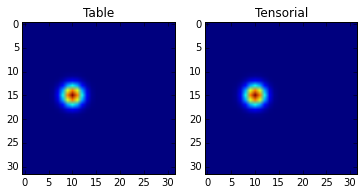

In [57]:
#print K_data.shape
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(np.reshape( K_data ,(32,32)).T)
axarr[0].set_title('Table')
axarr[1].imshow(np.reshape( kt_ ,(32,32)).T)
axarr[1].set_title('Tensorial')

In [153]:
#Missing pixels
completes = range(0,1024)
completes  = np.delete(completes, incompletes).astype(int)
print len(completes)

1023


In [154]:
Kx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1),'rbf', gamma=(2*sigmax)**-2)
Ky = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1),'rbf', gamma=(2*sigmay)**-2)
Kt = Kx*Ky
#Factorize
cnmf_kpg = KCNMF(Kt,num_bases=bases)
cnmf_kpg.factorize(niter=10)
print '(rbf kernel) rse:',np.linalg.norm(Kt - np.dot(cnmf_kpg.W,cnmf_kpg.H))/np.linalg.norm(Kt)
#Computing H
normalize = 0
lamb = 1e-10
print 'Computing Hs...'

auxpi4 = np.linalg.inv(np.dot(cnmf_kpg.W.T, cnmf_kpg.G)+ lamb*np.identity(bases))

Ktx = np.ones((len(completes),1))
#It's not feasible compute K(X,x) for pixel since all missing pixel are 0
Kxx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(X[incompletes], 0),'rbf', gamma=(2*sigmax)**-2)
Kyx = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(Y[incompletes], 0),'rbf', gamma=(2*sigmay)**-2)
Ktx = Kxx*Kyx
#Ktx = Ksx+Kix
H4_i = np.squeeze(np.dot(auxpi4, np.dot(cnmf_kpg.G.T, Ktx) ))
if normalize == 1:
    H4_i = (H4_i+abs(min(H4_i))) / sum(H4_i+abs(min(H4_i)))
if normalize == 2:
    H4_i = abs(H4_i)
if normalize == 3:
    H4_i = np.maximum(H4_i,0)
print '...Hs computed'

print 'Computing pre-image...'
normalize_alpha = 1
Pixel_preim = np.copy(Pixel)
rse_f = []
gamma_t = (2*sigmax)**-2+(2*sigmay)**-2

print 'Compute pre-image for object',incompletes
alpha = np.dot(cnmf_kpg.G, H4_i) #np.mean(cnmf_kg.H,0)
if normalize_alpha == 1:
    alpha = (alpha+abs(min(alpha))) / sum(alpha+abs(min(alpha)))
if normalize_alpha == 2:
    alpha = abs(alpha)
if normalize_alpha == 3:
    alpha = np.maximum(alpha,0)
#try:                
Pixel_preim, trainErrorskl = kernel.preimage(np.stack((Pixel[completes].T,np.zeros(len(completes)).T), axis = 1), alpha, 'rbf', gamma=gamma_t)
print Pixel_preim
print '...pre-images computed'

(rbf kernel) rse: 0.260854772586
Computing Hs...
...Hs computed
Computing pre-image...
Compute pre-image for object 335
[[ 0.00032998  0.        ]]
...pre-images computed


<h3>OKMF</h3>
$$\Phi(X)_{n\times l} = \Phi(X)_{n\times l}W_{l\times r}H_{l\times r}$$
$$\Phi(x_i) =  \Phi(X)Wh_i$$
\begin{align}
(\Phi(X) W )^+ \Phi(x_i ) = & h_i\\
(W^T\Phi(X)^T\Phi(X)W)^{−1}W^T\Phi(X)^T\Phi(x_i) = & h_i\\
(W^T KW)^{-1}W^T K(X, x_i ) = & h_i\\
\end{align}
$$ [\varphi_1 \; \varphi_2 \; \cdots \varphi_l] \left[ \begin{array}{c}
K(x_1, x_i) \\
K(x_2, x_i) \\
\cdots\\
K(x_l, x_i) \end{array} \right] = h_i.$$

$$h_i= \sum_{j=1}^l\varphi_jK(x_j,x_i)$$



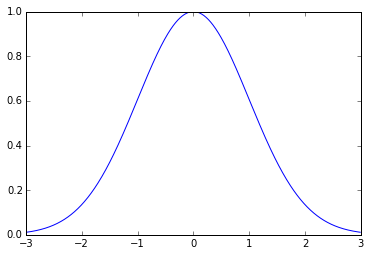

In [159]:
x = np.arange(-3,3,0.01)
plt.plot(x,np.exp(-x**2/2))

In [21]:
Kx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1),'rbf', gamma=(2*sigmax)**-2)
Ky = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1),'rbf', gamma=(2*sigmay)**-2)
Kt = Kx*Ky
#Factorize
cnmf_kpg = KCNMF(Kt,num_bases=bases)
cnmf_kpg.factorize(niter=10)
print '(rbf kernel) rse:',np.linalg.norm(Kt - np.dot(cnmf_kpg.W,cnmf_kpg.H))/np.linalg.norm(Kt)
#Computing H
normalize = 0
lamb = 1e-10
print 'Computing Hs...'

auxpi4 = np.dot(np.linalg.inv(np.dot(np.dot(cnmf_kpg.G.T,Kt),cnmf_kpg.G)),cnmf_kpg.G.T)

Ktx = np.ones((len(completes),1))
#It's not feasible compute K(X,x) for pixel since all missing pixel are 0
Kxx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(X[incompletes], 0),'rbf', gamma=(2*sigmax)**-2)
Kyx = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(Y[incompletes], 0),'rbf', gamma=(2*sigmay)**-2)
Ktx = Kxx*Kyx
#Ktx = Ksx+Kix
H4_i = np.dot(auxpi4, Ktx )
if normalize == 1:
    H4_i = (H4_i+abs(min(H4_i))) / sum(H4_i+abs(min(H4_i)))
if normalize == 2:
    H4_i = abs(H4_i)
if normalize == 3:
    H4_i = np.maximum(H4_i,0)
print '...Hs computed'

print 'Computing pre-image...'
normalize_alpha = 1
Pixel_preim = np.copy(Pixel)
rse_f = []
gamma_t = (2*sigmax)**-2+(2*sigmay)**-2

print 'Compute pre-image for object',incompletes
alpha = np.dot(cnmf_kpg.G, H4_i) #np.mean(cnmf_kg.H,0)
if normalize_alpha == 1:
    alpha = (alpha+abs(min(alpha))) / sum(alpha+abs(min(alpha)))
if normalize_alpha == 2:
    alpha = abs(alpha)
if normalize_alpha == 3:
    alpha = np.maximum(alpha,0)
#try:                
Pixel_preim, trainErrorskl = kernel.preimage(np.stack((Pixel[completes].T,np.zeros(len(completes)).T), axis = 1), alpha, 'rbf', gamma=gamma_t)
print Pixel_preim
print '...pre-images computed'

(rbf kernel) rse: 0.255479469289
Computing Hs...
...Hs computed
Computing pre-image...
Compute pre-image for object 335
[[  1.77945605e-10   0.00000000e+00]]
...pre-images computed


In [24]:
print 'Computing pre-image...'
normalize_alpha = 0
Pixel_preim = np.copy(Pixel)
rse_f = []
gamma_t = (2*sigmax)**-2+(2*sigmay)**-2

print 'Compute pre-image for object',incompletes
alpha = np.dot(cnmf_kpg.G, H4_i) #np.mean(cnmf_kg.H,0)
#alpha = np.dot(cnmf_kpg.W, H4_i) #np.mean(cnmf_kg.H,0)
if normalize_alpha == 1:
    alpha = (alpha+abs(min(alpha))) / sum(alpha+abs(min(alpha)))*100
if normalize_alpha == 2:
    alpha = abs(alpha)
if normalize_alpha == 3:
    alpha = np.maximum(alpha,0)
if normalize_alpha == 4:
    alpha = (alpha-min(alpha))/(max(alpha)-min(alpha))
if normalize_alpha == 5:
    alpha = alpha*10
#try:                
Pixel_preim, trainErrorskl = kernel.preimage(np.stack((Pixel[completes].T,np.zeros(len(completes)).T), axis = 1), alpha, 'rbf', gamma=gamma_t)
print Pixel_preim
print '...pre-images computed'

Computing pre-image...
Compute pre-image for object 335
[[  9.88788664e-11  -0.00000000e+00]]
...pre-images computed


In [25]:
Pixel_preim = np.dot(Pixel[completes].T, alpha)
print Pixel_preim

130.063987265


(1023, 1023)


/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


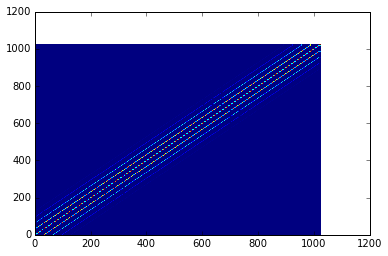

In [17]:
print Kt.shape
#plt.pcolor(np.reshape( K_data ,(32,32)).T)
plt.pcolor(Kt)

In [26]:
print H4_i.shape, auxpi4.shape, alpha.shape, Ktx.shape

(300,) (300, 300) (1023,) (1023, 1)


(300,)


<matplotlib.colorbar.Colorbar instance at 0x7f9bcc2fad40>

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


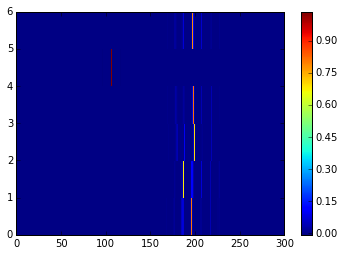

In [26]:
print H4_i.shape
Hs_comp = np.stack((H4_i, cnmf_kpg.H[:,334]))
Hs_comp = np.vstack((cnmf_kpg.H[:,335], Hs_comp))
Hs_comp = np.vstack((cnmf_kpg.H[:,336], Hs_comp))
Hs_comp = np.vstack((cnmf_kpg.H[:,333], Hs_comp))
Hs_comp = np.vstack((cnmf_kpg.H[:,332], Hs_comp))
plt.pcolor(Hs_comp)
plt.colorbar()
#Mpix = 

In [60]:
F = np.dot(cnmf_kpg.W, cnmf_kpg.H[:,335])
F.shape

(1023,)

10 15


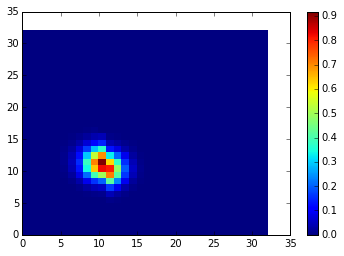

In [62]:
plt.pcolor(np.reshape( np.append([0], F) ,(32,32)).T) 
plt.colorbar()
print X[335],Y[335]

In [63]:
lamb = 0.0000001
auxpi4 = np.linalg.inv(np.dot(cnmf_kpg.W.T, cnmf_kpg.G)+ lamb*np.identity(bases))


In [64]:
incompletes = 335
Kxx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(X[incompletes], 0),'rbf', gamma=(2*sigmax)**-2)
Kyx = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(Y[incompletes], 0),'rbf', gamma=(2*sigmay)**-2)
Ktx = Kxx*Kyx
H4_i = np.squeeze(np.dot(auxpi4, np.dot(cnmf_kpg.G.T, Ktx) ))

<matplotlib.colorbar.Colorbar instance at 0x7f2011f70ab8>

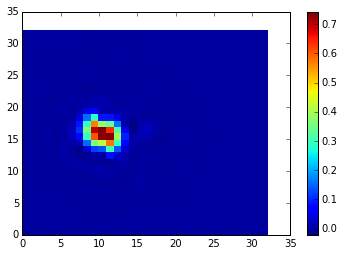

In [65]:
F1 = np.dot(cnmf_kpg.W, H4_i)
plt.pcolor(np.reshape( np.append([0], F1) ,(32,32)).T) 
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f2011b5f440>

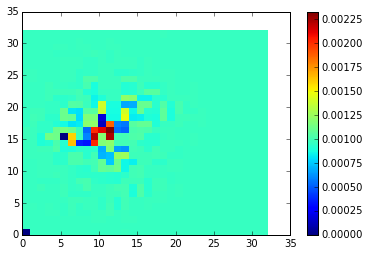

In [66]:
plt.pcolor(np.reshape( np.append([0], alpha) ,(32,32)).T) 
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f2011e3b830>

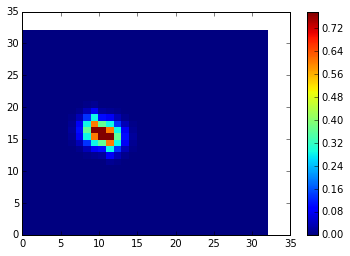

In [67]:
plt.pcolor(np.reshape( np.append([0], Ktx) ,(32,32)).T) 
plt.colorbar()

In [28]:
#alpha*Pixel
Pixel_preim = np.dot(alpha, Pixel[completes])

In [47]:
#avg
pix_inc = incompletes
avg_intp = 0
neigh_pix = (X[pix_inc])*32+Y[pix_inc]-1 #(up)
avg_intp += Pixel[neigh_pix]
neigh_pix = (X[pix_inc]-1)*32+Y[pix_inc] #(left)
avg_intp += Pixel[neigh_pix]
neigh_pix = (X[pix_inc]+1)*32+Y[pix_inc] #(righ)    
avg_intp += Pixel[neigh_pix]
neigh_pix = (X[pix_inc])*32+Y[pix_inc]+1 #(down)
avg_intp += Pixel[neigh_pix]
neigh_pix = (X[pix_inc]-1)*32+Y[pix_inc]-1 #(up-left)
avg_intp += Pixel[neigh_pix]
neigh_pix = (X[pix_inc]-1)*32+Y[pix_inc]+1 #(down-left)
avg_intp += Pixel[neigh_pix]
neigh_pix = (X[pix_inc]+1)*32+Y[pix_inc]-1 #(up-right)
avg_intp += Pixel[neigh_pix]
neigh_pix = (X[pix_inc]+1)*32+Y[pix_inc]+1 #(down-right)
avg_intp += Pixel[neigh_pix]

Pixel_preim = avg_intp/8

RSE** 1.414213562


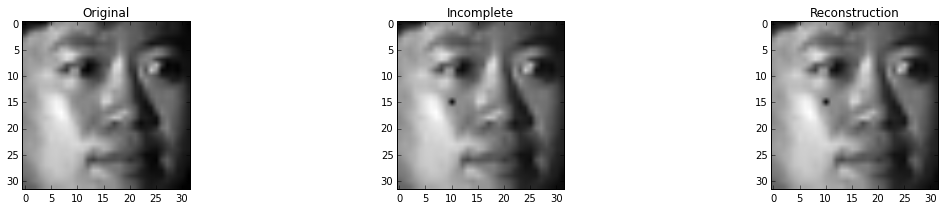

In [53]:
f, axarr = plt.subplots(1, 3)
axarr[0].imshow( np.reshape(MF[idx_inc[10]],(32,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original')
aux_ci = np.copy(MF[idx_inc[10]])
aux_ci[incompletes] = 0
axarr[1].imshow( np.reshape(aux_ci,(32,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete')
auximg = np.copy(MF[idx_inc[10]])
auximg[incompletes] = max(0,Pixel_preim[0,0])
#auximg[incompletes] = Pixel_preim
axarr[2].imshow( np.reshape(auximg,(32,32)).T, cmap='Greys_r' )
axarr[2].set_title('Reconstruction')
f.set_size_inches(19,3)
f.savefig('/home/rajaquep/outcomes/foo.png')
#print 'RSE', np.linalg.norm(MF[idx_inc[10]] - Pixel_preim)/np.linalg.norm(MF[idx_inc[10]])
print 'RSE**', np.linalg.norm(MF[idx_inc[10]][incompletes] - Pixel_preim)/np.linalg.norm(MF[idx_inc[10]][incompletes])

In [54]:
print MF[idx_inc[10]][incompletes], Pixel_preim

70 [[  3.66759378e-08   0.00000000e+00]]


<h2>Upgrading pre-image method </h2>

Using the fixed point iteration method for Gaussian kernel we derivate the next formulation:

$$ x^*_{t+1} = \frac{\sum_{i=1}^n\alpha_i exp(-||\hat{x}^*_t-\hat{x_i}||^2/2\sigma^2)x_i}{\sum_{i=1}^n\alpha_i exp(-||\hat{x}^*_t-\hat{x}_i||^2/2\sigma^2)}$$

Where $exp(-||\hat{x}^*_t-\hat{x_i}||^2/2\sigma^2)$ corresponds to the kernel computed for pixel coordinates and $x_i$ is the $i$ pixel intensity.

$\hat{x}$ is apriori known since that keep pixel coordenates information

In [93]:
print 'Computing pre-image...'
normalize_alpha = 0
Pixel_preim = np.copy(Pixel)
rse_f = []
sigmai = 1

print 'Compute pre-image for object',incompletes
alpha = np.dot(cnmf_kpg.G, H4_i) #np.mean(cnmf_kg.H,0)
#alpha = np.dot(cnmf_kpg.W, H4_i) #np.mean(cnmf_kg.H,0)
if normalize_alpha == 1:
    alpha = (alpha+abs(min(alpha))) / sum(alpha+abs(min(alpha)))*100
if normalize_alpha == 2:
    alpha = abs(alpha)
if normalize_alpha == 3:
    alpha = np.maximum(alpha,0)
if normalize_alpha == 4:
    alpha = (alpha-min(alpha))/(max(alpha)-min(alpha))
if normalize_alpha == 5:
    alpha = alpha*10
#try:
Kxx = kernel._get_kernel(np.stack((X[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(X[incompletes], 0),'rbf', gamma=(2*sigmax)**-2)
Kyx = kernel._get_kernel(np.stack((Y[completes].T,np.zeros(len(completes)).T), axis = 1), np.append(Y[incompletes], 0),'rbf', gamma=(2*sigmay)**-2)
Ktx = Kxx*Kyx
print Ktx.shape
Pixel_preim, trainErrorskl = kernel.pixel_preimage(Pixel[completes], Ktx, alpha, 'rbf', gamma=(2*sigmai)**-2)
print Pixel_preim
print '...pre-images computed'

Computing pre-image...
Compute pre-image for object [   4    6    8    9   10   12   13   15   16   18   19   21   22   23   24
   29   31   34   35   39   41   42   47   49   51   53   54   55   58   60
   62   66   72   75   77   79   80   81   84   87   88   90   91   92   94
   97   99  100  102  104  107  108  110  111  112  114  115  116  118  122
  124  125  126  128  129  130  132  136  137  138  141  142  145  146  147
  149  150  151  152  153  154  157  158  160  162  163  164  165  167  168
  170  171  174  175  177  180  181  182  183  184  185  186  187  190  191
  193  194  195  198  200  201  208  209  211  212  214  215  216  218  219
  220  221  222  225  227  230  232  236  241  242  246  247  248  249  250
  252  253  254  255  256  259  264  266  267  268  269  270  271  272  276
  277  279  280  281  285  287  291  292  296  298  299  301  303  304  307
  310  313  318  319  320  321  324  326  327  329  335  336  339  340  341
  342  343  350  352  354  355  358 

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 2 while Y.shape[1] == 512

In [50]:
print Pixel[completes].shape
print Pixel_preim.shape

(1023,)
(1,)


<h2>Comparing reconstructions</h2>

<h1> Naïve models for pixel reconstruction</h1>


In [19]:
#Average model an pixel pix_inc is computed as the average of pixel neightbors of distance 1
def avg_model(pix_inc):
    avg_intp = 0
    cnt = 0
    neigh_pix = (X[pix_inc])*32+Y[pix_inc]-1 #(up)
    if neigh_pix >= 0 and neigh_pix < 1024 and not(neigh_pix in incompletes):
        cnt += 1
        avg_intp += Pixel[neigh_pix]
    neigh_pix = (X[pix_inc]-1)*32+Y[pix_inc] #(left)
    if neigh_pix >= 0 and neigh_pix < 1024 and not(neigh_pix in incompletes):
        cnt += 1
        avg_intp += Pixel[neigh_pix]
    neigh_pix = (X[pix_inc]+1)*32+Y[pix_inc] #(righ)    
    if neigh_pix >= 0 and neigh_pix < 1024 and not(neigh_pix in incompletes):
        cnt += 1
        avg_intp += Pixel[neigh_pix]
    neigh_pix = (X[pix_inc])*32+Y[pix_inc]+1 #(down)
    if neigh_pix >= 0 and neigh_pix < 1024 and not(neigh_pix in incompletes):
        cnt += 1
        avg_intp += Pixel[neigh_pix]
    neigh_pix = (X[pix_inc]-1)*32+Y[pix_inc]-1 #(up-left)
    if neigh_pix >= 0 and neigh_pix < 1024 and not(neigh_pix in incompletes):
        cnt += 1
        avg_intp += Pixel[neigh_pix]
    neigh_pix = (X[pix_inc]-1)*32+Y[pix_inc]+1 #(down-left)
    if neigh_pix >= 0 and neigh_pix < 1024 and not(neigh_pix in incompletes):
        cnt += 1
        avg_intp += Pixel[neigh_pix]
    neigh_pix = (X[pix_inc]+1)*32+Y[pix_inc]-1 #(up-right)
    if neigh_pix >= 0 and neigh_pix < 1024 and not(neigh_pix in incompletes):
        cnt += 1
        avg_intp += Pixel[neigh_pix]
    neigh_pix = (X[pix_inc]+1)*32+Y[pix_inc]+1 #(down-right)
    if neigh_pix >= 0 and neigh_pix < 1024 and not(neigh_pix in incompletes):
        cnt += 1
        avg_intp += Pixel[neigh_pix]
    try:
        return avg_intp/cnt
    except ZeroDivisionError:
        return avg_intp

In [20]:
#Check average value from each reconstructed pixel
#print 'Pixel:', incompletes[100]
#print X[incompletes[100]], Y[incompletes[100]], X[incompletes[100]]*32+Y[incompletes[100]]
#print 'Pixel intensity:',Pixel[X[incompletes[100]]*32+Y[incompletes[100]]]
#Neighbours pixels

avg_intpv = []
for pix_inc in incompletes:
    avg_intpv.append(avg_model(pix_inc)) 
    

512 512
[ 4.35964459  4.35964492  4.35964587  4.35970799  4.37417253  4.33452503
  4.32903279  4.32828748  4.32877356  4.33083517]
[17.0, 30.0, 75.5, 75.25, 75.5, 72.0, 75.0, 72.0, 72.0, 0]
[13 37 69 74 72 73 75 72 68 65]
0 141.666666667
[[ 13.          37.          69.          74.          72.          73.
   75.          72.          68.          65.        ]
 [  4.35964459   4.35964492   4.35964587   4.35970799   4.37417253
    4.33452503   4.32903279   4.32828748   4.32877356   4.33083517]
 [ 17.          30.          75.5         75.25        75.5         72.
   75.          72.          72.           0.        ]]


<matplotlib.colorbar.Colorbar instance at 0x7f4c877e49e0>

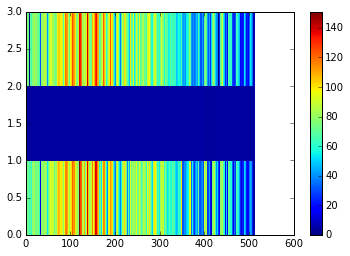

In [25]:
print len(avg_intpv), len(Pixel_preim[incompletes])
print Pixel_preim[incompletes[0:10]]
print avg_intpv[0:10]
print MF[idx_inc[10]][incompletes[0:10]]
print min(avg_intpv), max(avg_intpv)
Mpix = np.stack((Pixel_preim[incompletes], avg_intpv))
Mpix = np.vstack((MF[idx_inc[10]][incompletes], Mpix))
print Mpix[:,0:10]
plt.pcolor(Mpix)
plt.colorbar()
#print 'Error:', np.linalg.norm(avg_intpv - Pixel_preim[incompletes])

RSE 0.0380897774014
RSE** 0.116835554826


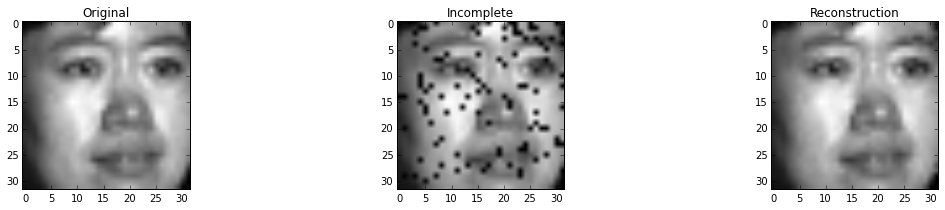

In [21]:
#Average predictor (lazy model)
AvgM = Pixel_preim
AvgM[incompletes] = avg_intpv
f, axarr = plt.subplots(1, 3)
axarr[0].imshow( np.reshape(MF[idx_inc[10]],(32,32)).T, cmap='Greys_r' )
axarr[0].set_title('Original')
axarr[1].imshow( np.reshape(MF_ci[idx_inc[10]],(32,32)).T, cmap='Greys_r' )
axarr[1].set_title('Incomplete')
axarr[2].imshow( np.reshape(AvgM,(32,32)).T, cmap='Greys_r' )
axarr[2].set_title('Reconstruction')
f.set_size_inches(19,3)
f.savefig('/home/rajaquep/outcomes/foo.png')
print 'RSE', np.linalg.norm(MF[idx_inc[10]] - Pixel_preim)/np.linalg.norm(MF[idx_inc[10]])
print 'RSE**', np.linalg.norm(MF[idx_inc[10]][incompletes] - Pixel_preim[incompletes])/np.linalg.norm(MF[idx_inc[10]][incompletes])

In [24]:
#PCA


-11.512925464970229

In [ ]:
#Convex-NMF